**Data Mining Project, midterm 2021/2022**

**Authors:** Niko Dalla Noce, Alessandro Ristori, Giuseppe Lombardi

# **Task 3 Predictive Analysis**

## **Import the libraries and load the player dataset**

First we have to import the necessary libraries to work within our project.

In [ ]:
!pip install scikit-plot
!pip install pytorch-tabnet
!pip install wittgenstein
!pip install imblearn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sn
import math
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from scikitplot.metrics import plot_roc

from imblearn.over_sampling import RandomOverSampler

The dataset coming from the data preparation task is saved on github.

In [ ]:
!git clone 'https://github.com/nikodallanoce/DataMiningProject/'

fatal: destination path 'DataMiningProject' already exists and is not an empty directory.


**Load the players' profile dataset**

In [ ]:
df_players = pd.read_parquet('/content/DataMiningProject/DM_14_TASK2/players_dataset.gzip')
df_players

,name,sex,age,ioc,ht,hand,t_won,p_wins,wins,p_w_Hard,w_Hard,p_w_Clay,w_Clay,p_w_Grass,w_Grass,p_aces,p_double_faults,p_1st_in,mean_1st_in,p_1st_won,mean_1st_won,p_2nd_won,mean_2nd_won,mean_sv_points,p_bp_saved,mean_bp_saved,mean_bp_faced,rank,rank_points,age_range,ht_range,rank_range
0,alexander zverev,M,24,DEU,198,R,16,70.08,260,68.44,154,74.77,83,65.71,23,10.72,5.40,64.78,52,74.55,39,49.86,14,81,60.90,3,5,5,7263,"[21,27]",>190,top 10
8,frank moser,M,40,DEU,193,R,0,45.45,5,50.00,3,50.00,1,33.33,1,7.70,2.82,57.00,40,72.97,29,47.16,14,70,68.83,4,7,848,19,>34,>190,top 1000
13,ruben ramirez hidalgo,M,41,ESP,183,R,0,52.27,46,57.89,11,50.72,35,0.00,0,5.37,5.03,57.46,39,69.42,27,48.31,14,69,61.38,4,7,341,142,>34,"[181,190]",top 500
14,tommy haas,M,39,DEU,188,R,0,30.00,6,0.00,0,33.33,4,40.00,2,5.56,4.80,61.23,52,68.67,35,53.85,17,85,68.52,5,8,248,205,>34,"[181,190]",top 250
15,toshihide matsui,M,41,JPN,180,R,0,37.74,20,38.78,19,25.00,1,0.00,0,8.89,5.72,58.14,36,70.63,25,49.53,12,61,61.29,3,5,752,21,>34,"[171,180]",top 1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4253,alexandar lazov,M,29,BGR,182,U,0,53.12,17,33.33,3,60.87,14,0.00,0,6.35,5.62,61.90,39,67.88,26,48.08,11,63,61.04,4,7,828,16,"[28,34]","[181,190]",top 1000
4254,david o hare,M,27,IRL,184,U,0,26.67,4,23.08,3,0.00,0,50.00,1,8.04,9.07,61.40,43,70.32,30,44.07,12,71,62.75,4,6,2221,0,"[21,27]","[181,190]",top 1000
4255,kuan-yi lee,M,23,TWN,173,R,0,47.06,16,48.48,16,0.00,0,0.00,0,4.40,3.13,67.87,42,65.75,28,49.78,10,62,58.59,3,6,573,42,"[21,27]","[171,180]",top 1000
4256,ben patael,M,22,ISR,192,U,0,41.03,16,45.45,10,35.29,6,0.00,0,6.63,4.40,61.33,41,65.82,27,48.92,12,67,56.25,3,6,562,45,"[21,27]",>190,top 1000


In [ ]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 0 to 4257
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             1600 non-null   object  
 1   sex              1600 non-null   object  
 2   age              1600 non-null   Int32   
 3   ioc              1600 non-null   object  
 4   ht               1600 non-null   Int32   
 5   hand             1600 non-null   object  
 6   t_won            1600 non-null   Int32   
 7   p_wins           1600 non-null   float64 
 8   wins             1600 non-null   Int32   
 9   p_w_Hard         1600 non-null   float64 
 10  w_Hard           1600 non-null   Int32   
 11  p_w_Clay         1600 non-null   float64 
 12  w_Clay           1600 non-null   Int32   
 13  p_w_Grass        1600 non-null   float64 
 14  w_Grass          1600 non-null   Int32   
 15  p_aces           1600 non-null   float64 
 16  p_double_faults  1600 non-null   float64 


## **Dataset preparation**

Carico il dataset derivante dal task precedente

In [ ]:
df_players = pd.read_parquet('/content/DataMiningProject/DM_14_TASK2/players_dataset.gzip')
df_players = df_players.sample(frac=1).reset_index(drop=True)


We can discretize the categorical variables and then use them for the classification task. NB: for some classifiers it may not be a good practice (example: classifiers which use distance metrics for the classifications, such as KNN)


In [ ]:
def discretize_data(dataset, variables):
    '''
    Function to discretize the variables
    
        input: the dataset and the list of variables' names to discretize
    '''
    for variable in variables:
        # Get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        # Generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        # Add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [ ]:
def move_columns(df, cols_to_move, new_index):
    """
    This method re-arranges the columns in a dataframe to place the desired columns at the desired index.
    Usage:
        df = move_columns(df, ['Rev'], 2) 
    Input:
        df: Dataframe
        cols_to_move: The names of the columns to move. They must be a list
        new_index: The 0-based location to place the columns.
    Output:
        Dataframe with the columns re-arranged
    """
    other = [c for c in df if c not in cols_to_move]
    start = other[0:new_index]
    end = other[new_index:]
    return df[start + cols_to_move + end]

Seleziono le feature categoriche da convertire in numeriche

In [ ]:
variables = ['sex', 'ioc', 'hand']
df_players = discretize_data(df_players, variables)

Assegno le label ai giocatori e vedo se il dataset è sbilanciato oppure no. I giocatori forti hanno label 1, i deboli 0.

In [ ]:
df_players['label'] = np.where(df_players['rank_range'].isin(['top 10', 'top 25', 'top 50', 'top 100', 'top 250']), 1, 0)
print(df_players['label'].value_counts())

0    1010
1     590
Name: label, dtype: int64


Elimino alcune colonne superflue ed in aggiunta, le feature categorizzate che sono state discretizzate. Infine, splitto il dataset in training set e validation set.

In [ ]:
df_players.drop(
        columns=['name', 'sex', 'ioc', 'hand', 'age_range', 'ht_range', 'rank_range', 'rank_points', 'rank',
                 'p_w_Hard', 'p_w_Clay', 'p_w_Grass', 'ioc_num', 'hand_num'],
        axis=1,
        inplace=True)
#label = df_players.pop('label')

Dal dataset originale, ne creo altri due: uno contentente solo i giocatori di sesso maschile, l'altro solo le giocatrici. Dopodichè visualizzo come sono distribuiti i giocatori forti rispetto a quelli deboli all'interno dei dataset.

In [ ]:
from sklearn.model_selection import train_test_split

df_players_female = df_players[df_players['sex_num'] == 0]
print("Female distribution\n" + str(df_players_female['label'].value_counts()))
label_f = df_players_female.pop('label')
df_players_female.pop('sex_num')
#train_set_f, test_set_f, train_label_f, test_label_f = train_test_split(df_players_female, label, stratify=label, test_size=0.10)

df_players_male = df_players[df_players['sex_num'] == 1]
print("Male distribution\n" + str(df_players_male['label'].value_counts()))
label_m = df_players_male.pop('label')
df_players_male.pop('sex_num')

#train_set_m, test_set_m, train_label_m, test_label_m = train_test_split(df_players_male, label, stratify=label, test_size=0.10)
label = df_players.pop('label')

Female distribution
1    304
0    194
Name: label, dtype: int64
Male distribution
0    816
1    286
Name: label, dtype: int64


Con questo metodo si seleziona il dataset con cui eseguire il task di classificazione. Si può scegliere se utilizzare il dataset costituito da soli giocatori, da sole giocatrici oppure da entrambi.

In [ ]:
def dataset_selector(TARGET, sampler=None, normalize = True, test_size=0.1):
  ss = StandardScaler()
  if TARGET not in ['male', 'female', 'both']:
    assert False
  elif TARGET=='male':  

    train_set, test_set, train_label, test_label = train_test_split(df_players_male, label_m, stratify=label_m, test_size=test_size)

  elif TARGET=='female':

    train_set, test_set, train_label, test_label = train_test_split(df_players_female, label_f, stratify=label_f, test_size=test_size)

  elif TARGET =='both':
    train_set, test_set, train_label, test_label = train_test_split(df_players, label, stratify=label, test_size=test_size)

  if normalize:
    train_set = pd.DataFrame(ss.fit_transform(train_set), index=train_set.index, columns=train_set.columns)
    test_set = pd.DataFrame(ss.fit_transform(test_set), index=test_set.index, columns=test_set.columns)

  if sampler is not None:
    train_set, train_label = sampler.fit_resample(train_set, train_label)

  print("Distribution\n" +str(train_label.value_counts()))
  return train_set, test_set, train_label, test_label


Definisco il metodo per analizzare i risultati di ogni classificatore.

In [ ]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['bad', 'good']))

In [ ]:
def print_scores(classifier, train_set, train_label , test_set, test_label, is_keras=False):
  train_pred = classifier.predict(train_set)
  test_pred = classifier.predict(test_set)

  if is_keras:
    train_pred = np.argmax(train_pred, 1)
    test_pred = np.argmax(test_pred, 1)

  print("Train set scores")
  report_scores(train_label, train_pred)
  print("\n______________________________________________________\n")

  print("Test set scores")
  report_scores(test_label, test_pred)

In [ ]:
def plot_feature_hist(classifier, features):
  plt.bar(features, classifier.feature_importances_)
  plt.xticks(rotation='vertical')
  plt.tight_layout()
  plt.show()

Il dataset è sbilanciato, proviamo ad applicare l'oversampling sulla classe i cui record sono in minoranza.

In [ ]:
sampler = RandomOverSampler(sampling_strategy='auto')
train_set, test_set, train_label, test_label = dataset_selector(TARGET='female', sampler = None, normalize = False)

Distribution
1    273
0    175
Name: label, dtype: int64


## **Classification**

In questa sezione si confrontano diversi algoritmi di classificazione, quali: Decision tree, Naive Bayes, Random forest, Adaboost, Rule based, KNN, SVM, Neural Network e Tab Net.

L'approccio utilizzato per ogni algoritmo è stato il seguente:


1. si esegue la K-Fold Cross validation per cercare i migliori iperparametri per ciascun modello.

2. si valuta il modello addestrato utilizzando i migliori iparametri trovati al passo precedente, utilizzando le seguenti metriche: precision, recall ed F1.

3. si calcola la matrice di confusione e la ROC curve.

4. nel caso in cui il modello offra l'explainability, si mostra quanto ogni feature incida sull'output fornito dal modello e/o le regole per la classificazione prodotte dallo stesso.




### **Decision tree**

In [ ]:
dt = tree.DecisionTreeClassifier(splitter='best', max_depth = 4, criterion = 'gini')
dt.fit(train_set, train_label)
print_scores(dt, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

         bad       0.87      0.83      0.85       175
        good       0.89      0.92      0.91       273

    accuracy                           0.88       448
   macro avg       0.88      0.87      0.88       448
weighted avg       0.88      0.88      0.88       448


_______________________________________________________

Test set scores
              precision    recall  f1-score   support

         bad       0.56      0.53      0.54        19
        good       0.72      0.74      0.73        31

    accuracy                           0.66        50
   macro avg       0.64      0.63      0.64        50
weighted avg       0.66      0.66      0.66        50



#### Grid search for best hyperparameters

In [ ]:
#define the parameters' values you want to try
param_dist = {"max_depth": [2,3,4,5,6,7],
              "min_samples_split": list(np.arange(2, 21, 2)),
              "min_samples_leaf": list(np.arange(2, 21, 2)),
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}]}
#define the number of iters
n_iter_search = 1000
#define the model
dt = tree.DecisionTreeClassifier(splitter='best')
#define the grid search
grid_search = RandomizedSearchCV(dt, param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=-1,
                            verbose=10, 
                            scoring=make_scorer(accuracy_score),
                            cv = 4)

#GridSearchCV()
#run the grid search
grid_search.fit(train_set, train_label)

Fitting 4 folds for each of 1000 candidates, totalling 4000 fits


RandomizedSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_iter=1000,
                   n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None,
                                                         {0: 0.2, 1: 0.8},
                                                         {0: 0.3, 1: 0.7},
                                                         {0: 0.4, 1: 0.6}],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 4, 5, 6, 7],
                                        'min_samples_leaf': [2, 4, 6, 8, 10, 12,
                                                             14, 16, 18, 20],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14, 16, 18,
                                                              20]},
                   scoring=make_scorer(accuracy_score), verbose=1

In [ ]:
print('Best setting parameters ', grid_search.best_params_)
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][grid_search.best_index_], grid_search.cv_results_['std_test_score'][grid_search.best_index_])

Best setting parameters  {'min_samples_split': 2, 'min_samples_leaf': 16, 'max_depth': 2, 'criterion': 'entropy', 'class_weight': {0: 0.4, 1: 0.6}}
Mean and std of this setting  0.8236607142857144 0.031170178669127115


In [ ]:
best_param = grid_search.best_params_
dt = tree.DecisionTreeClassifier( criterion=best_param['criterion'],
                             max_depth=best_param['max_depth'], 
                             min_samples_split=best_param['min_samples_split'],
                             min_samples_leaf=best_param['min_samples_leaf'],
                             class_weight = best_param['class_weight']) 
dt = dt.fit(train_set, train_label)
print_scores(dt, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

         bad       0.85      0.69      0.76       175
        good       0.82      0.92      0.87       273

    accuracy                           0.83       448
   macro avg       0.84      0.81      0.82       448
weighted avg       0.83      0.83      0.83       448


_______________________________________________________

Test set scores
              precision    recall  f1-score   support

         bad       0.67      0.53      0.59        19
        good       0.74      0.84      0.79        31

    accuracy                           0.72        50
   macro avg       0.70      0.68      0.69        50
weighted avg       0.71      0.72      0.71        50



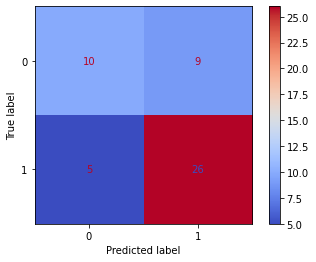

In [ ]:
#it is possible to plot the confusion matrix 
ConfusionMatrixDisplay.from_estimator(dt, test_set, test_label, cmap='coolwarm')
plt.show() 

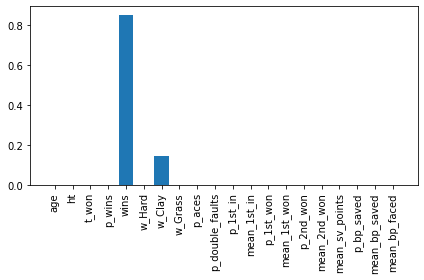

In [ ]:
plot_feature_hist(dt, train_set.columns.values)

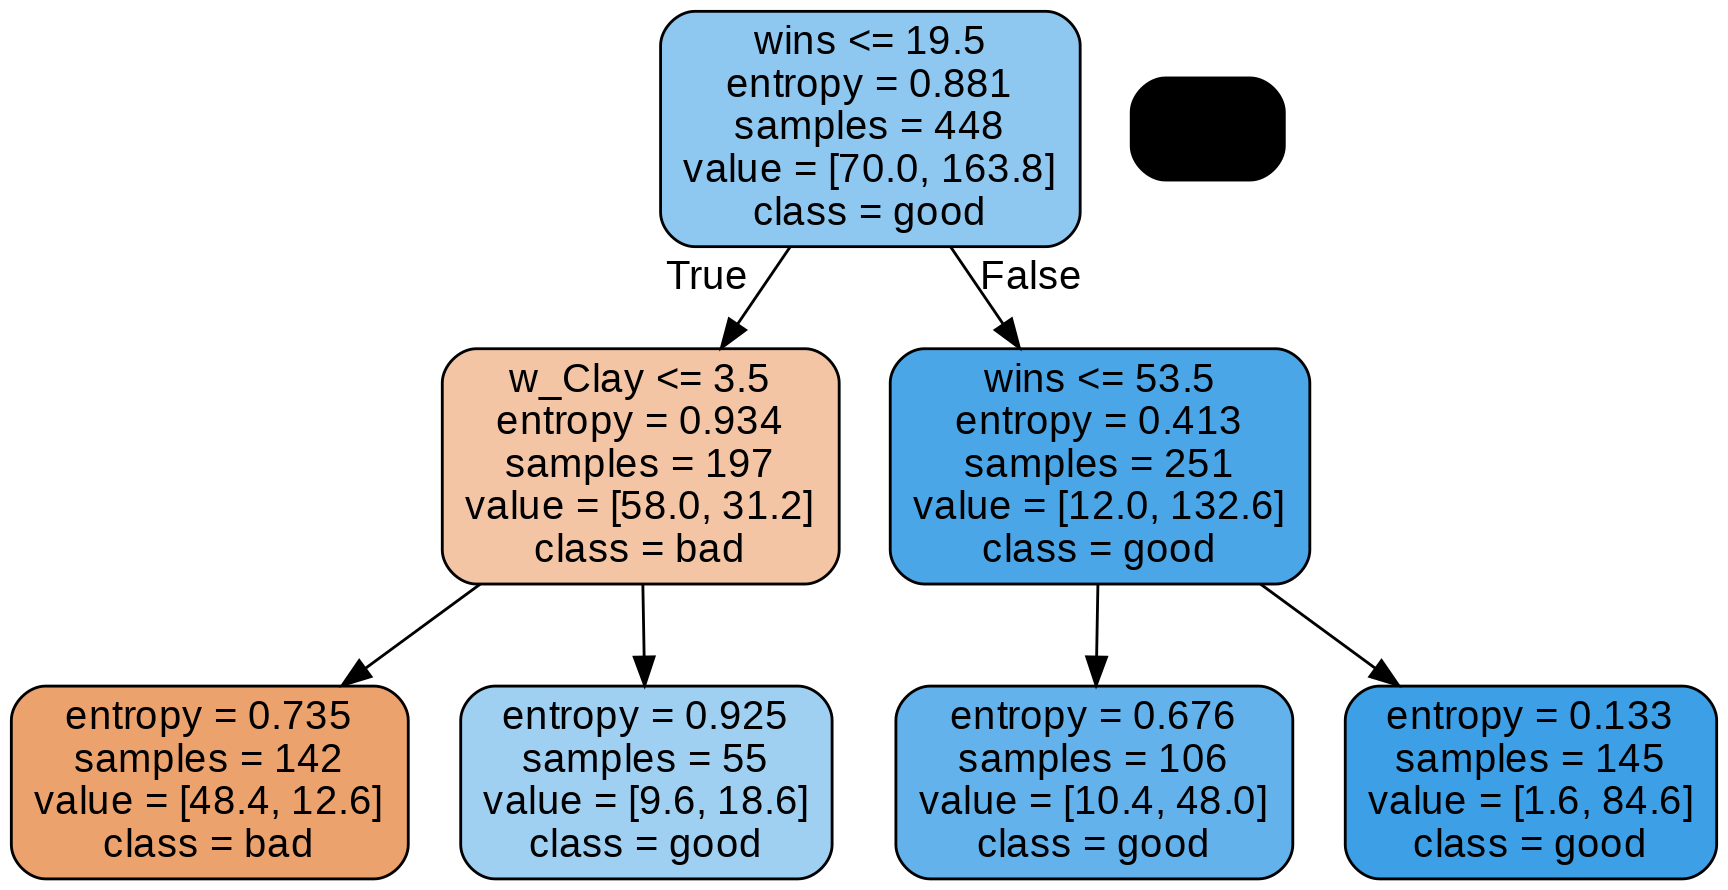

In [ ]:
import graphviz, pydotplus
from IPython.display import Image  
# DOT data
dot_data = tree.export_graphviz(dt, out_file = None, 
                                feature_names= list(train_set.columns.values),
                                class_names=['bad', 'good'],
                                filled=True,
                                rounded = True)
# Draw graph

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
#pydot_graph.write_png('original_tree.png')
pydot_graph.set_size('"18, 18!"')
Image(pydot_graph.create_png())

### **Naive Bayes**

In [ ]:
#define and fit the model
gnb = GaussianNB()
gnb.fit(train_set, train_label)

#compute the performance of the model
print_scores(gnb, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

         bad       0.64      0.90      0.75       175
        good       0.92      0.67      0.77       273

    accuracy                           0.76       448
   macro avg       0.78      0.79      0.76       448
weighted avg       0.81      0.76      0.76       448


_______________________________________________________

Test set scores
              precision    recall  f1-score   support

         bad       0.47      0.79      0.59        19
        good       0.78      0.45      0.57        31

    accuracy                           0.58        50
   macro avg       0.62      0.62      0.58        50
weighted avg       0.66      0.58      0.58        50



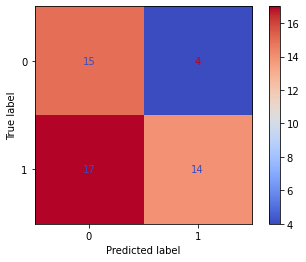

In [ ]:
#it is possible to plot the confusion matrix 
ConfusionMatrixDisplay.from_estimator(gnb, test_set, test_label, cmap = 'coolwarm')
plt.show() 

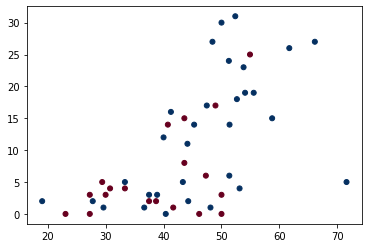

In [ ]:
from sklearn.datasets import make_blobs
plt.scatter(test_set.iloc[:, 3].values, test_set.iloc[:, 6].values, c=test_label.values, s=25, cmap='RdBu');

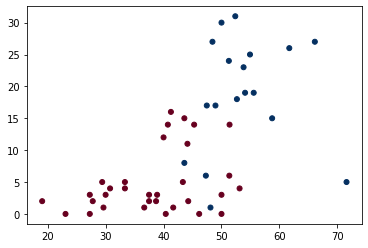

In [ ]:
plt.scatter(test_set.iloc[:, 3].values, test_set.iloc[:, 6].values, c=gnb.predict(test_set), s=25, cmap='RdBu');

### **Random forest**

In [ ]:
#define and fit a random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, 
                             criterion='gini',
                             max_features=5,
                             max_depth=4,
                             min_samples_split=2,
                             min_samples_leaf=8,
                             bootstrap=True) 
rf = rf.fit(train_set, train_label)

#compute the performance of the model
print_scores(rf, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

         bad       0.83      0.81      0.82       175
        good       0.88      0.89      0.89       273

    accuracy                           0.86       448
   macro avg       0.85      0.85      0.85       448
weighted avg       0.86      0.86      0.86       448


_______________________________________________________

Test set scores
              precision    recall  f1-score   support

         bad       0.62      0.68      0.65        19
        good       0.79      0.74      0.77        31

    accuracy                           0.72        50
   macro avg       0.71      0.71      0.71        50
weighted avg       0.73      0.72      0.72        50



#### Grid search for best hyperparameters

In [ ]:
#define the parameters' values you want to try
param_dist = {"n_estimators": list(np.arange(50, 150, 10)),
              "max_depth": [2,3,4,5,6,7],
              "max_features": list(np.arange(2, len(train_set.iloc[0])//2 + 1, 1)),
              "min_samples_split": list(np.arange(2, 31, 2)),
              "min_samples_leaf": list(np.arange(2, 31, 2)),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}]}
#define the number of iters
n_iter_search = 200
#define the model
clf = RandomForestClassifier()
#define the grid search
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=-1,
                            verbose=10, 
                            scoring=make_scorer(accuracy_score),
                            cv = 4)
#run the grid search
grid_search.fit(train_set, train_label)

Fitting 4 folds for each of 200 candidates, totalling 800 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None,
                                                         {0: 0.2, 1: 0.8},
                                                         {0: 0.3, 1: 0.7},
                                                         {0: 0.4, 1: 0.6}],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 4, 5, 6, 7],
                                        'max_features': [2, 3, 4, 5, 6, 7, 8, 9,
                                                         10],
                                        'min_samples_leaf': [2, 4, 6, 8, 10, 12,
                                                             14, 16, 18, 20, 22,
                                                             24, 26, 28, 30]

In [ ]:
print('Best setting parameters ', grid_search.best_params_)
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][grid_search.best_index_], grid_search.cv_results_['std_test_score'][grid_search.best_index_])

Best setting parameters  {'n_estimators': 60, 'min_samples_split': 18, 'min_samples_leaf': 30, 'max_features': 3, 'max_depth': 3, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': True}
Mean and std of this setting  0.8258928571428572 0.009982446328124076


In [ ]:
best_param = grid_search.best_params_
rf = RandomForestClassifier(n_estimators=best_param['n_estimators'], 
                             criterion=best_param['criterion'],
                             max_features=best_param['max_features'],
                             max_depth=best_param['max_depth'], 
                             min_samples_split=best_param['min_samples_split'],
                             min_samples_leaf=best_param['min_samples_leaf'],
                             bootstrap=best_param['bootstrap'],
                             class_weight = best_param['class_weight']) 
rf = rf.fit(train_set, train_label)
#compute the performance of the model
print_scores(rf, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

         bad       0.79      0.79      0.79       175
        good       0.87      0.86      0.87       273

    accuracy                           0.84       448
   macro avg       0.83      0.83      0.83       448
weighted avg       0.84      0.84      0.84       448


_______________________________________________________

Test set scores
              precision    recall  f1-score   support

         bad       0.59      0.68      0.63        19
        good       0.79      0.71      0.75        31

    accuracy                           0.70        50
   macro avg       0.69      0.70      0.69        50
weighted avg       0.71      0.70      0.70        50



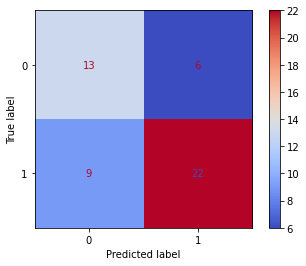

In [ ]:
#it is possible to plot the confusion matrix 
ConfusionMatrixDisplay.from_estimator(rf, test_set, test_label, cmap='coolwarm')
plt.show() 

### **AdaBoost**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(train_set, train_label)

print_scores(ada, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

         bad       0.84      0.87      0.85       175
        good       0.92      0.89      0.90       273

    accuracy                           0.88       448
   macro avg       0.88      0.88      0.88       448
weighted avg       0.89      0.88      0.88       448


_______________________________________________________

Test set scores
              precision    recall  f1-score   support

         bad       0.53      0.53      0.53        19
        good       0.71      0.71      0.71        31

    accuracy                           0.64        50
   macro avg       0.62      0.62      0.62        50
weighted avg       0.64      0.64      0.64        50



In [ ]:
base = tree.DecisionTreeClassifier(max_depth = 6)
ada_tree = AdaBoostClassifier(base_estimator = base, n_estimators=200, learning_rate=0.1)
ada_tree.fit(train_set, train_label)

print_scores(ada_tree, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

         bad       1.00      1.00      1.00       175
        good       1.00      1.00      1.00       273

    accuracy                           1.00       448
   macro avg       1.00      1.00      1.00       448
weighted avg       1.00      1.00      1.00       448


_______________________________________________________

Test set scores
              precision    recall  f1-score   support

         bad       0.50      0.53      0.51        19
        good       0.70      0.68      0.69        31

    accuracy                           0.62        50
   macro avg       0.60      0.60      0.60        50
weighted avg       0.62      0.62      0.62        50



#### Grid search for best hyperparameters

In [ ]:
#define the parameters' values you want to try
param_dist = {"n_estimators": list(np.arange(50, 300, 50)),
              "learning_rate": np.arange(0.01, 0.15, 0.03)}
#define the number of iters
n_iter_search = 20
#define the model
ada_tree = AdaBoostClassifier(base_estimator = base)
#define the grid search
grid_search = RandomizedSearchCV(ada_tree, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=-1,
                            verbose=10, 
                            scoring=make_scorer(accuracy_score),
                            cv = 4)
#run the grid search
grid_search.fit(train_set, train_label)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


RandomizedSearchCV(cv=4,
                   estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6)),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.01, 0.04, 0.07, 0.1 , 0.13]),
                                        'n_estimators': [50, 100, 150, 200,
                                                         250]},
                   scoring=make_scorer(accuracy_score), verbose=10)

In [ ]:
print('Best setting parameters ', grid_search.best_params_)
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][grid_search.best_index_], grid_search.cv_results_['std_test_score'][grid_search.best_index_])

Best setting parameters  {'n_estimators': 250, 'learning_rate': 0.04}
Mean and std of this setting  0.78125 0.02319710902994033


In [ ]:
best_param = grid_search.best_params_
ada_tree = AdaBoostClassifier(n_estimators=best_param['n_estimators'], 
                        learning_rate=best_param['learning_rate']) 
ada_tree = ada_tree.fit(train_set, train_label)
#compute the performance of the model
print_scores(ada_tree, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

         bad       0.81      0.82      0.81       175
        good       0.88      0.88      0.88       273

    accuracy                           0.85       448
   macro avg       0.84      0.85      0.85       448
weighted avg       0.85      0.85      0.85       448


_______________________________________________________

Test set scores
              precision    recall  f1-score   support

         bad       0.59      0.68      0.63        19
        good       0.79      0.71      0.75        31

    accuracy                           0.70        50
   macro avg       0.69      0.70      0.69        50
weighted avg       0.71      0.70      0.70        50



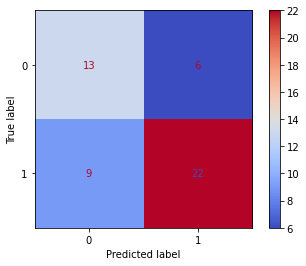

In [ ]:
#it is possible to plot the confusion matrix 
ConfusionMatrixDisplay.from_estimator(ada_tree, test_set, test_label, cmap='coolwarm')
plt.show() 

### **Rule based**

In [ ]:
#we run a grid search to find the best configuration of parameters' values
import wittgenstein as lw
ripper = lw.RIPPER()
param_grid = {"prune_size": [0.4, 0.5, 0.6, 0.7], "k": [1, 3, 5]}
grid_search = GridSearchCV(estimator=ripper, param_grid=param_grid)
grid_search.fit(train_set, train_label)

GridSearchCV(estimator=<RIPPER(prune_size=0.33, max_rule_conds=None, max_rules=None, n_discretize_bins=10, k=2, random_state=None, dl_allowance=64, verbosity=0, max_total_conds=None)>,
             param_grid={'k': [1, 3, 5], 'prune_size': [0.4, 0.5, 0.6, 0.7]})

In [ ]:
print('Best setting parameters ', grid_search.best_params_)
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][grid_search.best_index_], grid_search.cv_results_['std_test_score'][grid_search.best_index_])

Best setting parameters  {'k': 1, 'prune_size': 0.6}
Mean and std of this setting  0.7499875156054931 0.013589674877658041


In [ ]:
#define and fit the rule-based model
#this function requires only one dataset with the labels. 
#To do so, we concatenate the train_set and the train_label
import wittgenstein as lw
best_param = grid_search.best_params_
ripper = lw.RIPPER(k=best_param['k'], prune_size=best_param['prune_size'])
datas = pd.concat([train_set, train_label], axis=1)
ripper.fit(datas, class_feat='label', pos_class=1)

In [ ]:
#in this case the model is a set of rules
ripper.out_model()

[[w_Clay=>35.0] V
[w_Clay=10.0-16.0] V
[w_Clay=22.0-35.0] V
[w_Clay=16.0-22.0 ^ wins=84.0-121.0] V
[wins=38.0-61.0] V
[w_Clay=6.5-10.0] V
[w_Clay=16.0-22.0] V
[w_Clay=4.0-6.5] V
[mean_1st_in=41.0-42.0 ^ mean_2nd_won=10.0-11.0] V
[p_1st_won=63.49-64.75 ^ wins=6.0-10.0]]


In [ ]:
print_scores(ripper, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

         bad       0.79      0.78      0.78       175
        good       0.86      0.87      0.86       273

    accuracy                           0.83       448
   macro avg       0.82      0.82      0.82       448
weighted avg       0.83      0.83      0.83       448


_______________________________________________________

Test set scores
              precision    recall  f1-score   support

         bad       0.57      0.63      0.60        19
        good       0.76      0.71      0.73        31

    accuracy                           0.68        50
   macro avg       0.67      0.67      0.67        50
weighted avg       0.69      0.68      0.68        50



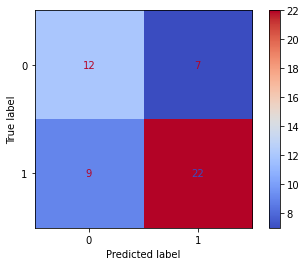

In [ ]:
#it is possible to plot the confusion matrix 
ConfusionMatrixDisplay.from_estimator(ripper, test_set, test_label, cmap= 'coolwarm')
plt.show() 

### **KNN**

In [ ]:
#drop the categorical features
train_set_no_cat = train_set.loc[:,~train_set.columns.str.contains('_num', case=False)] 
test_set_no_cat = test_set.loc[:,~test_set.columns.str.contains('_num', case=False)] 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
#['auto', 'ball_tree', 'kd_tree', 'brute']
knn = KNeighborsClassifier(n_neighbors=60, algorithm='auto', metric='minkowski').fit(train_set_no_cat, train_label)

#compute the performance of the model
print_scores(knn, train_set_no_cat, train_label, test_set_no_cat, test_label)

Train set scores
              precision    recall  f1-score   support

         bad       0.73      0.80      0.77       175
        good       0.86      0.81      0.84       273

    accuracy                           0.81       448
   macro avg       0.80      0.81      0.80       448
weighted avg       0.81      0.81      0.81       448


_______________________________________________________

Test set scores
              precision    recall  f1-score   support

         bad       0.62      0.68      0.65        19
        good       0.79      0.74      0.77        31

    accuracy                           0.72        50
   macro avg       0.71      0.71      0.71        50
weighted avg       0.73      0.72      0.72        50



#### Grid search for best hyperparameters

In [ ]:
#to find the best set of parameter setting, we can run a grid search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

#define the parameters' values you want to try
param_dist = {"n_neighbors": list(np.arange(5, 100, 2)),
              "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
              "p": [1, 2],
              "metric": ['minkowski']}
#define the number of iters
n_iter_search = 100
#define the model
knn = KNeighborsClassifier()
#define the grid search
grid_search = RandomizedSearchCV(knn, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=-1, 
                            scoring=make_scorer(accuracy_score),
                            cv = 4)
#run the grid search
grid_search.fit(train_set_no_cat, train_label)

RandomizedSearchCV(cv=4, estimator=KNeighborsClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'metric': ['minkowski'],
                                        'n_neighbors': [5, 7, 9, 11, 13, 15, 17,
                                                        19, 21, 23, 25, 27, 29,
                                                        31, 33, 35, 37, 39, 41,
                                                        43, 45, 47, 49, 51, 53,
                                                        55, 57, 59, 61, 63, ...],
                                        'p': [1, 2]},
                   scoring=make_scorer(accuracy_score))

In [ ]:
print('Best setting parameters ', grid_search.best_params_)
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][grid_search.best_index_], grid_search.cv_results_['std_test_score'][grid_search.best_index_])

Best setting parameters  {'p': 1, 'n_neighbors': 19, 'metric': 'minkowski', 'algorithm': 'auto'}
Mean and std of this setting  0.8258928571428571 0.02045792720962426


In [ ]:
best_param = grid_search.best_params_
knn = KNeighborsClassifier(n_neighbors=best_param['n_neighbors'],
                          algorithm=best_param['algorithm'],
                          metric=best_param['metric'],
                          p = best_param['p'])
knn = knn.fit(train_set_no_cat, train_label)

#compute the performance of the model
print_scores(knn, train_set_no_cat, train_label, test_set_no_cat, test_label)

Train set scores
              precision    recall  f1-score   support

         bad       0.74      0.80      0.77       175
        good       0.86      0.82      0.84       273

    accuracy                           0.81       448
   macro avg       0.80      0.81      0.81       448
weighted avg       0.82      0.81      0.81       448


_______________________________________________________

Test set scores
              precision    recall  f1-score   support

         bad       0.62      0.68      0.65        19
        good       0.79      0.74      0.77        31

    accuracy                           0.72        50
   macro avg       0.71      0.71      0.71        50
weighted avg       0.73      0.72      0.72        50



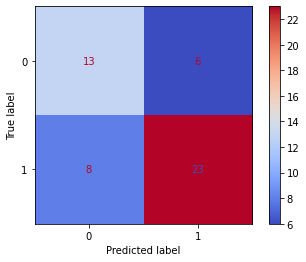

In [ ]:
#it is possible to plot the confusion matrix 
ConfusionMatrixDisplay.from_estimator(knn, test_set_no_cat, test_label, cmap='coolwarm')
plt.show()

### **SVM**

In [ ]:
#linear,poly,rbf,sigmoid,precomputed
svm = SVC(kernel='sigmoid', C = 2, gamma='scale', probability=True)
svm.fit(train_set, train_label)

#compute the performance of the model
print_scores(svm, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

         bad       0.68      0.86      0.76       175
        good       0.89      0.74      0.81       273

    accuracy                           0.79       448
   macro avg       0.79      0.80      0.79       448
weighted avg       0.81      0.79      0.79       448


_______________________________________________________

Test set scores
              precision    recall  f1-score   support

         bad       0.52      0.74      0.61        19
        good       0.78      0.58      0.67        31

    accuracy                           0.64        50
   macro avg       0.65      0.66      0.64        50
weighted avg       0.68      0.64      0.64        50



#### Grid search for best hyperparameters

In [ ]:
#to find the best set of parameter setting, we can run a grid search
#define the parameters' values you want to try
param_dist = {"C": list(np.arange(1, 100, 4)),
              "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
              "degree": list(np.arange(2, 10, 1)),
              "class_weight":['balanced', {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}]}
#define the number of iters
n_iter_search = 10
#define the model
svm = SVC()
#define the grid search
grid_search = RandomizedSearchCV(svm, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs= -1,
                            verbose = 3, 
                            scoring=make_scorer(accuracy_score),
                            cv = 4)
#run the grid search
grid_search.fit(train_set, train_label)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomizedSearchCV(cv=4, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [1, 5, 9, 13, 17, 21, 25, 29, 33,
                                              37, 41, 45, 49, 53, 57, 61, 65,
                                              69, 73, 77, 81, 85, 89, 93, 97],
                                        'class_weight': ['balanced',
                                                         {0: 0.3, 1: 0.7},
                                                         {0: 0.4, 1: 0.6}],
                                        'degree': [2, 3, 4, 5, 6, 7, 8, 9],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   scoring=make_scorer(accuracy_score), verbose=3)

In [ ]:
print('Best setting parameters ', grid_search.best_params_)
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][grid_search.best_index_], grid_search.cv_results_['std_test_score'][grid_search.best_index_])

Best setting parameters  {'kernel': 'poly', 'degree': 5, 'class_weight': 'balanced', 'C': 9}
Mean and std of this setting  0.8058035714285714 0.009729685141831857


In [ ]:
best_param = grid_search.best_params_
svm = SVC(C=best_param['C'],
          kernel=best_param['kernel'],
          degree=best_param['degree'],
          class_weight = best_param['class_weight'],
          probability=True)
svm = svm.fit(train_set, train_label)

#compute the performance of the model
print_scores(svm, train_set, train_label, test_set, test_label)

Train set scores
              precision    recall  f1-score   support

         bad       0.73      0.89      0.80       175
        good       0.92      0.79      0.85       273

    accuracy                           0.83       448
   macro avg       0.82      0.84      0.83       448
weighted avg       0.84      0.83      0.83       448


_______________________________________________________

Test set scores
              precision    recall  f1-score   support

         bad       0.57      0.68      0.62        19
        good       0.78      0.68      0.72        31

    accuracy                           0.68        50
   macro avg       0.67      0.68      0.67        50
weighted avg       0.70      0.68      0.68        50



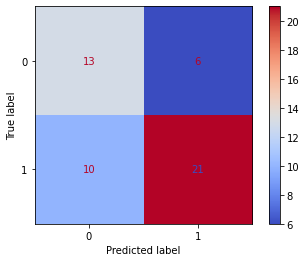

In [ ]:
#it is possible to plot the confusion matrix 
ConfusionMatrixDisplay.from_estimator(svm, test_set, test_label, cmap='coolwarm')
plt.show()

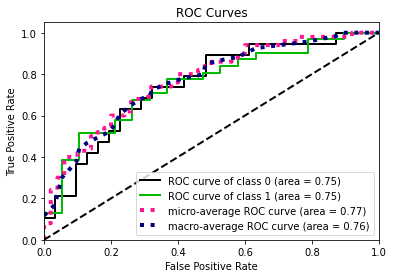

In [ ]:
test_pred_proba = svm.predict_proba(test_set)
plot_roc(test_label.values, test_pred_proba)
plt.show()

### **Neural network**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [ ]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [ ]:
columns_to_one_hot = list(train_set.columns[train_set.columns.str.contains('_num', case=False)])
train_set_nn = pd.get_dummies(train_set, columns= columns_to_one_hot)
test_set_nn = pd.get_dummies(test_set, columns= columns_to_one_hot)
train_set_nn
#test_set_nn = (tf.constant(test_set_nn, dtype=tf.float32), tf.constant(test_label, dtype=tf.int32))

,age,ht,t_won,p_wins,wins,w_Hard,w_Clay,w_Grass,p_aces,p_double_faults,p_1st_in,mean_1st_in,p_1st_won,mean_1st_won,p_2nd_won,mean_2nd_won,mean_sv_points,p_bp_saved,mean_bp_saved,mean_bp_faced
265,22,178,0,60.00,18,3,11,4,9.40,7.94,56.73,45,69.29,31,46.62,16,79,56.96,4,7
1310,30,178,1,38.26,57,40,8,9,1.71,5.78,66.51,43,58.16,25,41.75,9,65,51.48,4,9
470,19,180,0,30.77,4,4,0,0,0.15,14.37,54.04,27,53.46,14,34.53,8,51,39.62,3,8
173,20,176,0,52.50,21,9,8,4,2.88,7.41,55.95,42,62.39,26,43.01,14,76,54.07,5,10
845,31,169,0,36.90,31,9,21,1,1.95,2.12,65.57,44,56.56,25,47.51,11,67,51.27,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599,21,173,0,47.37,9,3,5,1,6.07,4.32,64.24,50,65.65,32,46.79,13,78,61.25,5,8
545,29,165,0,50.00,24,17,6,1,2.37,4.03,64.51,43,62.84,27,43.72,10,67,59.07,5,8
1240,23,185,0,49.30,70,50,16,4,7.39,6.71,55.98,39,68.61,27,44.33,13,70,56.58,4,7
619,27,178,3,59.88,97,65,27,5,4.47,4.76,57.85,39,64.73,25,47.14,13,68,54.78,4,7


In [ ]:
ss:StandardScaler = StandardScaler()

In [ ]:
v = np.asarray(train_label, dtype=np.float32).reshape((train_label.shape[0], 1))
patterns = tf.convert_to_tensor(ss.fit_transform(train_set), dtype=tf.float32)
targets =  tf.convert_to_tensor(train_label.T, dtype=tf.int32)
train_set_nn = tf.data.Dataset.from_tensor_slices((patterns,targets))
patterns = tf.convert_to_tensor(ss.fit_transform(test_set), dtype=tf.float32)
targets =  tf.convert_to_tensor(test_label.T, dtype=tf.int32)
test_set_nn = tf.data.Dataset.from_tensor_slices((patterns,targets))

In [ ]:
BUFFER_SIZE = 20000
DS_SIZE= 2**15

def make_dataset(dataset, batch_size):
    dataset = dataset.shuffle(batch_size, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size, drop_remainder=False, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.prefetch(tf.data.AUTOTUNE).cache()

batch_size =  16 * strategy.num_replicas_in_sync
with strategy.scope():
  train_set_nn = make_dataset(train_set_nn, batch_size)
  test_set_nn = make_dataset(test_set_nn, batch_size)

In [ ]:
monitor = "val_accuracy"
with strategy.scope():
  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor=monitor,
      min_delta=0.0002,
      patience=30,
      verbose=1,
      mode="auto",
      baseline=None,
      restore_best_weights=True,
  )

  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./checkpoint/model_weights.h5',
    monitor=monitor,
    verbose=0,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    overwrite=True)

In [ ]:
#from tf.keras.regularizers import l2

shape= train_set.shape
dropout = 0.4
def create_model():
  input = tf.keras.Input(shape=(shape[1]), dtype="float32", name='input')
  x = tf.keras.layers.Dense(256, activation='elu', name='dense1')(input)
  x = tf.keras.layers.LayerNormalization()(x)
  l1 = tf.keras.layers.Dropout(dropout)(x)

  x = tf.keras.layers.Dense(96, activation='elu', name='dense2')(l1)
  x = tf.keras.layers.LayerNormalization()(x)
  x2 = tf.keras.layers.Dropout(dropout)(x)

  '''x = tf.keras.layers.Dense(96, activation='elu', name='dense3')(l1)
  x = tf.keras.layers.LayerNormalization()(x)
  x3 = tf.keras.layers.Dropout(dropout)(x)

  x = tf.keras.layers.Add()([x2, x3])
  x = tf.keras.layers.Dropout(dropout)(x)'''
  x = tf.keras.layers.Dense(64, activation='elu', name='dense4')(x2)
  #x = tf.keras.layers.Dropout(dropout)(x)
  x = tf.keras.layers.LayerNormalization()(x)
  
  out = tf.keras.layers.Dense(2, activation='softmax', name='out')(x)

  return tf.keras.Model(input, out)

with strategy.scope():
  
  model = create_model()
  model.compile(optimizer=tf.keras.optimizers.Adam(4e-2),
                loss= tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])
#tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
history = model.fit(train_set_nn,
                    epochs=100,
                    validation_data = test_set_nn,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
28/28 [==============================] - 2s 19ms/step - loss: 0.9168 - accuracy: 0.6853 - val_loss: 0.7182 - val_accuracy: 0.5800
Epoch 2/100
28/28 [==============================] - 0s 9ms/step - loss: 0.5069 - accuracy: 0.7656 - val_loss: 0.6786 - val_accuracy: 0.5800
Epoch 3/100
28/28 [==============================] - 0s 9ms/step - loss: 0.4784 - accuracy: 0.7969 - val_loss: 0.7111 - val_accuracy: 0.6400
Epoch 4/100
28/28 [==============================] - 0s 10ms/step - loss: 0.4487 - accuracy: 0.8058 - val_loss: 0.7287 - val_accuracy: 0.6000
Epoch 5/100
28/28 [==============================] - 0s 10ms/step - loss: 0.4200 - accuracy: 0.8214 - val_loss: 0.7480 - val_accuracy: 0.6600
Epoch 6/100
28/28 [==============================] - 0s 8ms/step - loss: 0.3949 - accuracy: 0.8304 - val_loss: 0.8519 - val_accuracy: 0.6600
Epoch 7/100
28/28 [==============================] - 0s 8ms/step - loss: 0.4302 - accuracy: 0.8192 - val_loss: 0.8284 - val_accuracy: 0.7200
Epoch 8/10

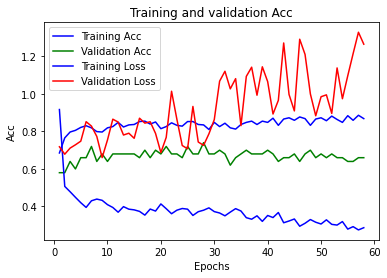

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training Acc')
plt.plot(epochs, val_acc, 'g', label='Validation Acc')
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
#compute the performance of the model
test_nn = ss.fit_transform(test_set.to_numpy())
train_nn = ss.fit_transform(train_set.to_numpy())

print_scores(model, train_nn, train_label, test_nn, test_label, True)

Train set scores
              precision    recall  f1-score   support

         bad       0.74      0.89      0.81       175
        good       0.92      0.79      0.85       273

    accuracy                           0.83       448
   macro avg       0.83      0.84      0.83       448
weighted avg       0.85      0.83      0.83       448


_______________________________________________________

Test set scores
              precision    recall  f1-score   support

         bad       0.65      0.68      0.67        19
        good       0.80      0.77      0.79        31

    accuracy                           0.74        50
   macro avg       0.73      0.73      0.73        50
weighted avg       0.74      0.74      0.74        50



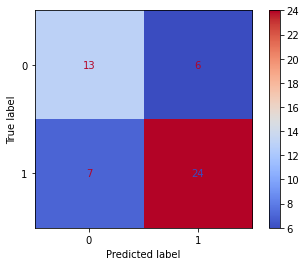

In [ ]:
#it is possible to plot the confusion matrix 
ConfusionMatrixDisplay.from_predictions(test_label, np.argmax(model.predict(test_nn), 1), cmap='coolwarm')

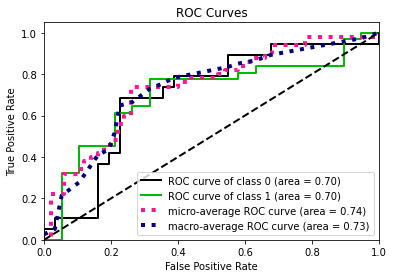

In [ ]:
plot_roc(test_label, model.predict(test_nn))
plt.show()

### **Tab Net**

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.metrics import Accuracy, AUC
import torch
from sklearn.preprocessing import StandardScaler

ss:StandardScaler = StandardScaler()

train_set_tab = ss.fit_transform(train_set.to_numpy())
test_set_tab = ss.fit_transform(test_set.to_numpy())

In [ ]:
tab_clf = TabNetClassifier(optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=5e-2))  #4e-2 for female, 6e-2 for male/both

tab_clf.fit(
  train_set_tab, train_label.to_numpy(),
  eval_set=[(test_set_tab, test_label.to_numpy())],
  eval_metric=[Accuracy]
)

Device used : cuda
epoch 0  | loss: 0.74006 | val_0_accuracy: 0.56    |  0:00:00s
epoch 1  | loss: 0.67325 | val_0_accuracy: 0.6     |  0:00:00s
epoch 2  | loss: 0.66158 | val_0_accuracy: 0.58    |  0:00:00s
epoch 3  | loss: 0.63157 | val_0_accuracy: 0.56    |  0:00:00s
epoch 4  | loss: 0.60569 | val_0_accuracy: 0.58    |  0:00:00s
epoch 5  | loss: 0.57756 | val_0_accuracy: 0.52    |  0:00:00s
epoch 6  | loss: 0.54999 | val_0_accuracy: 0.56    |  0:00:00s
epoch 7  | loss: 0.51473 | val_0_accuracy: 0.64    |  0:00:00s
epoch 8  | loss: 0.48778 | val_0_accuracy: 0.6     |  0:00:00s
epoch 9  | loss: 0.46381 | val_0_accuracy: 0.58    |  0:00:00s
epoch 10 | loss: 0.44484 | val_0_accuracy: 0.56    |  0:00:00s
epoch 11 | loss: 0.458   | val_0_accuracy: 0.6     |  0:00:00s
epoch 12 | loss: 0.42956 | val_0_accuracy: 0.62    |  0:00:00s
epoch 13 | loss: 0.43584 | val_0_accuracy: 0.58    |  0:00:01s
epoch 14 | loss: 0.40265 | val_0_accuracy: 0.56    |  0:00:01s
epoch 15 | loss: 0.40384 | val_0_acc

In [ ]:
#compute the performance of the model
print_scores(tab_clf, train_set_tab, train_label, test_set_tab, test_label)

Train set scores
              precision    recall  f1-score   support

         bad       0.67      0.66      0.67       175
        good       0.79      0.79      0.79       273

    accuracy                           0.74       448
   macro avg       0.73      0.73      0.73       448
weighted avg       0.74      0.74      0.74       448


_______________________________________________________

Test set scores
              precision    recall  f1-score   support

         bad       0.53      0.53      0.53        19
        good       0.71      0.71      0.71        31

    accuracy                           0.64        50
   macro avg       0.62      0.62      0.62        50
weighted avg       0.64      0.64      0.64        50



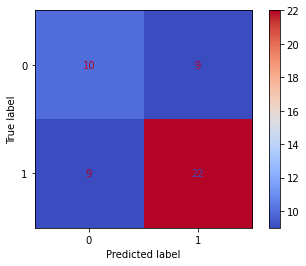

In [ ]:
y_pred = tab_clf.predict_proba(test_set_tab)
ConfusionMatrixDisplay.from_predictions(np.argmax(y_pred, 1), test_label, cmap='coolwarm')

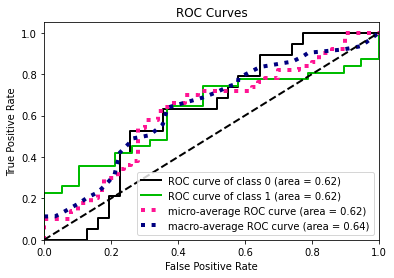

In [ ]:
plot_roc(test_label, y_pred)
plt.show()

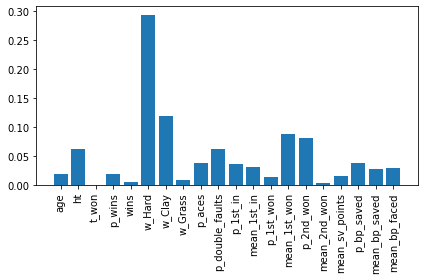

In [ ]:
plot_feature_hist(tab_clf, train_set.columns.values)

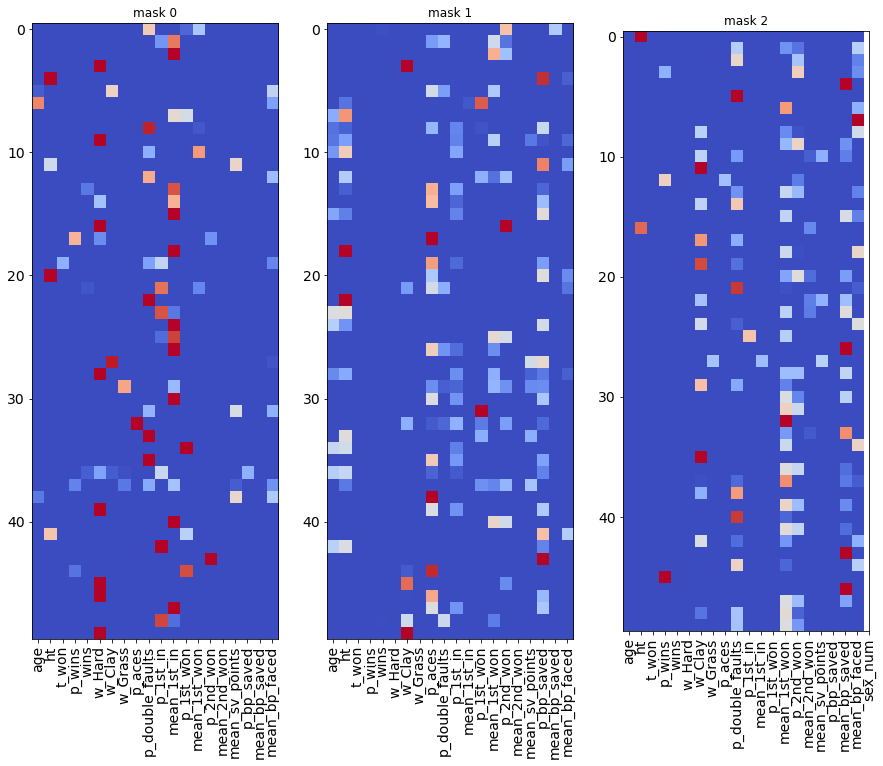

In [ ]:
from matplotlib.pyplot import Axes
explain_matrix, masks = tab_clf.explain(test_set_tab)
fig, axs = plt.subplots(1, len(masks), figsize=(15, 15), sharex=True)
for i in range(len(masks)):
    axs[i].imshow(masks[i][:60], cmap='coolwarm')
    axs[i].set_xticks(list(np.arange(0, len(df_players.columns.values), 1)))
    axs[i].set_xticklabels(df_players.columns.values, rotation=90)
    # We change the fontsize of minor ticks label 
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    axs[i].set_title(f"mask {i}")

## **Result comparison**

<Figure size 432x288 with 0 Axes>

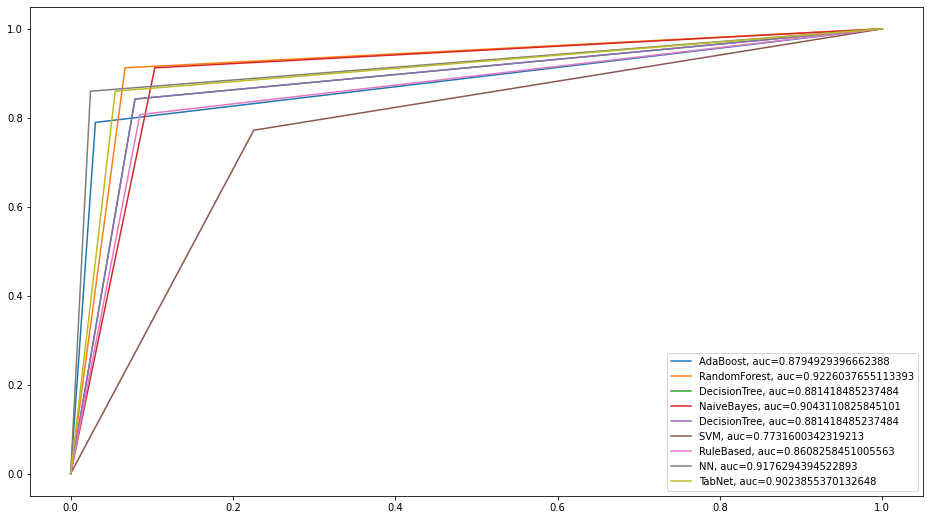

In [ ]:
plt.figure(0).clf()
plt.figure(figsize=(16,9))
def auc_plot(classifier, test_set, test_label, name, is_keras=False, proba=False):
  #if proba:
   # test_pred = classifier.predict_proba(test_set)
  #else:  
  test_pred = classifier.predict(test_set)
  if is_keras: 
    test_pred = np.argmax(test_pred, 1)

  fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred)
  auc = metrics.roc_auc_score(test_label, test_pred)
  plt.plot(fpr,tpr,label= name + ", auc=" + str(auc))

auc_plot(ada, test_set, test_label, "AdaBoost")
auc_plot(rf, test_set, test_label, "RandomForest")
auc_plot(dt, test_set, test_label, "DecisionTree")
auc_plot(gnb, test_set, test_label, "NaiveBayes")
auc_plot(dt, test_set, test_label, "DecisionTree")
auc_plot(svm, test_set, test_label, "SVM")
auc_plot(ripper, test_set, test_label, "RuleBased")
auc_plot(model, test_nn, test_label, "NN", True)
auc_plot(tab_clf, test_set_tab, test_label, "TabNet")

plt.legend(loc=0)